In [24]:
import os
import tarfile
import urllib
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
import emoji
import pickle
import pandas_profiling
from pandas.plotting import scatter_matrix
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-white')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

# Print multiple unassigned variables at end of cell when called
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# California Real Estate - Predicting Median House Value

The purpose of this project is illustrate proficiency in linear regression techniques and in building a data transformation pipeline. Its objective is to predict the median house values of housing "block groups" in California. A block group is the smallest geographical unit for which the US Census Bureau publishes sample data. Each block group typically has a population of 600-3,000 people. 

The data comes from the 1990 California census. It contains the following attributes:

* Longitude  
* Latitude
* Housing median age
* Total rooms
* Total bedrooms
* Population
* Households
* Median income
* Ocean proximity
* Median house value

To evaluate the performance of the model, I'll use the RMSE cost function.


## Fetch & Load Data

In [2]:
# fetch the data
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
# load the dataset
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

## EDA

In [4]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
profile_report = load_housing_data().profile_report()
profile_report

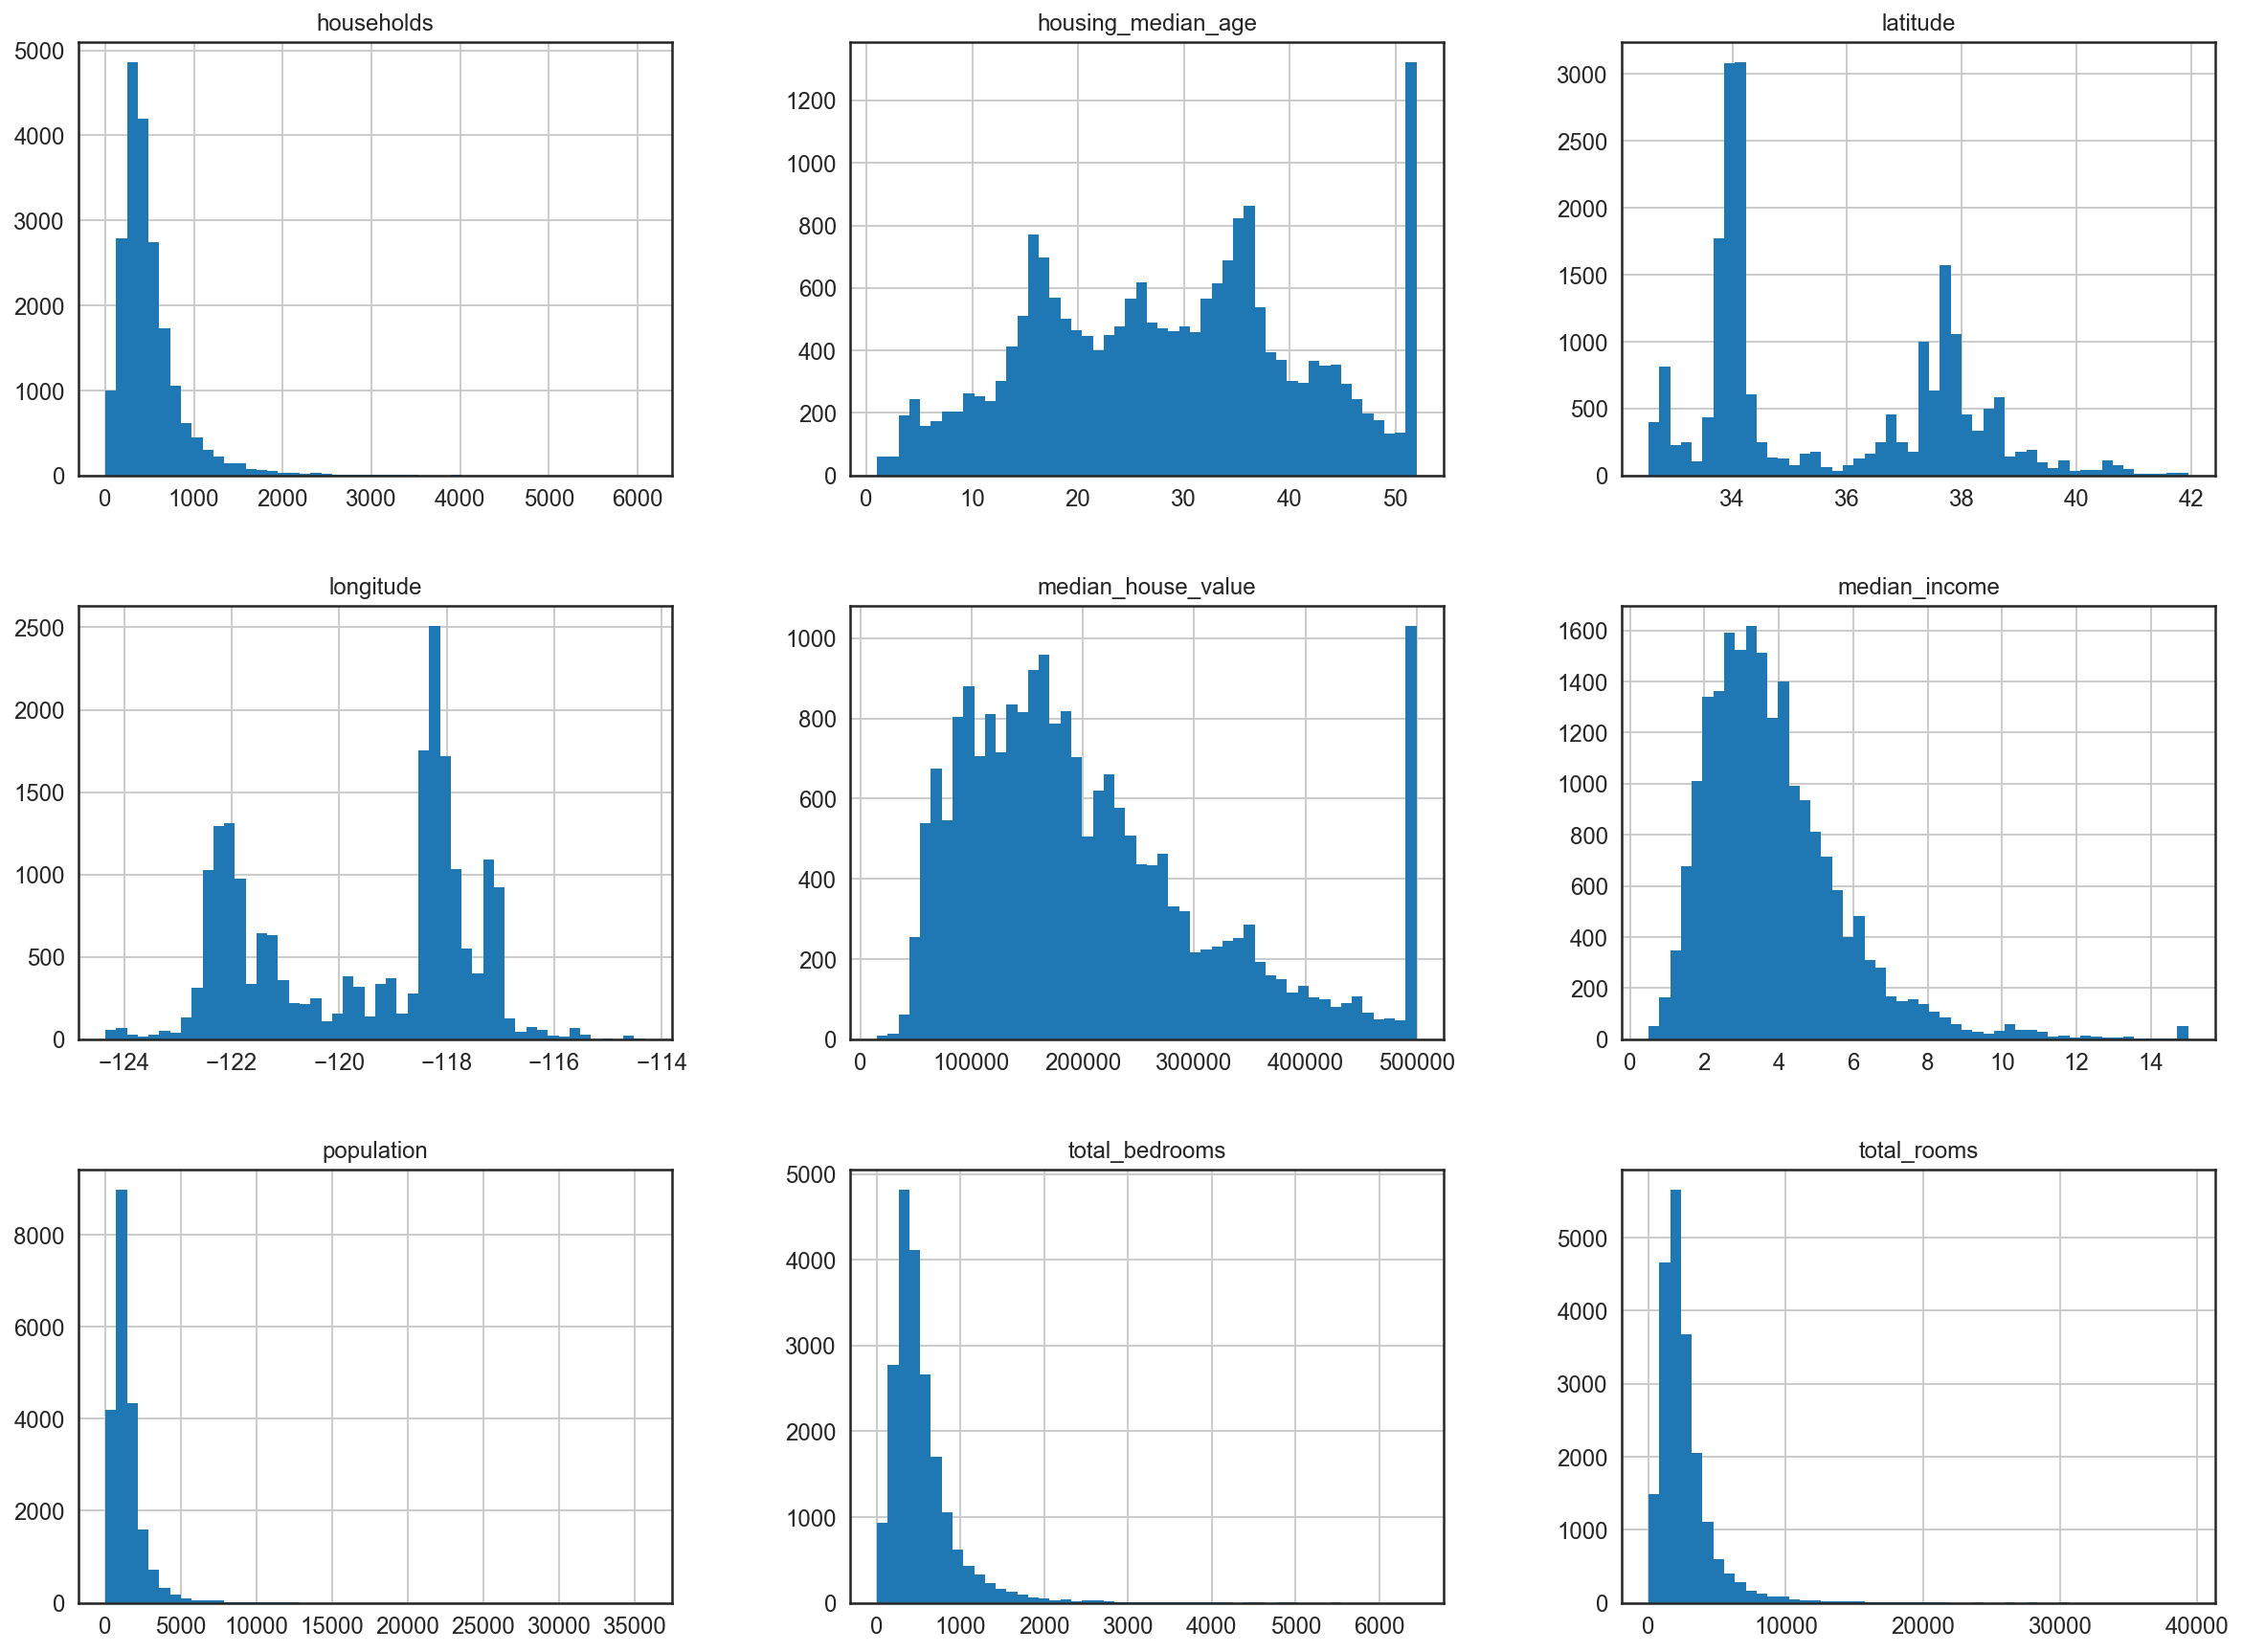

In [7]:
housing.hist(bins=50, figsize=(20,15));

There are a number of things to take away from this:  
1. The median income doesn't appear to be expressed in USD. Since we know this data represents a US housing market, it's reasonable to assume that this feature is represented in \\$10,000 increments. 
2. The housing median age and median house value appear to have been capped. This may be a problem, because we're supposed to be predicting house values. As it stands currently, ML alogorithms may learn that house values never go beyond a certain price.  
3. The scales of the attributes are vastly different. 
4. Most of the histograms are tail-heavy. We'll have to transform some of them to yield more normalized distributions.

## Cleaning

Let's ensure that our test set is representative of all of the median incomes, even those that are very high, so that it can provide adequate predictive signal. We'll create a new column called `income_cat`, which assigns a numerical categorical rating to each instance based on its median income value. Then we'll split the data and stratify it against this column.

### Create income_cat column

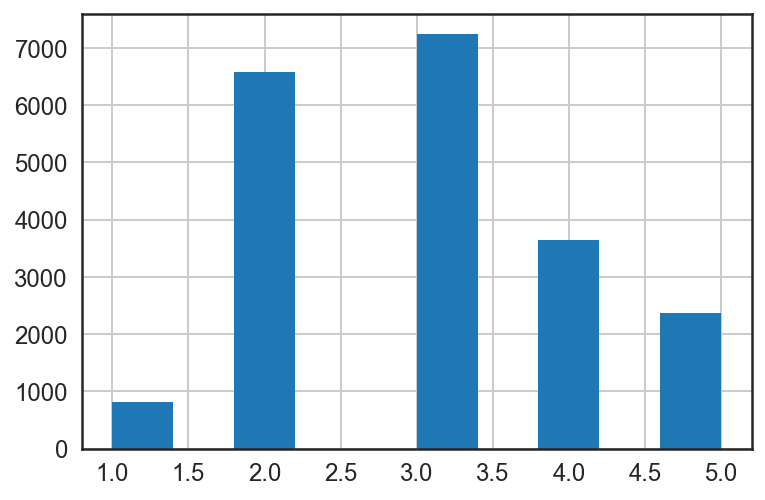

In [8]:
# create income_cat column 
housing['income_cat'] = pd.cut(housing['median_income'],
                              bins=[0, 1.5, 3, 4.5, 6, np.inf],
                              labels=[1,2,3,4,5])

housing['income_cat'].hist();

### Split the Data

In [9]:
train, test = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing['income_cat'])

In [10]:
# remove income_cat column to restore data to its original form
for set_ in (train, test):
    set_.drop('income_cat', axis=1, inplace=True)

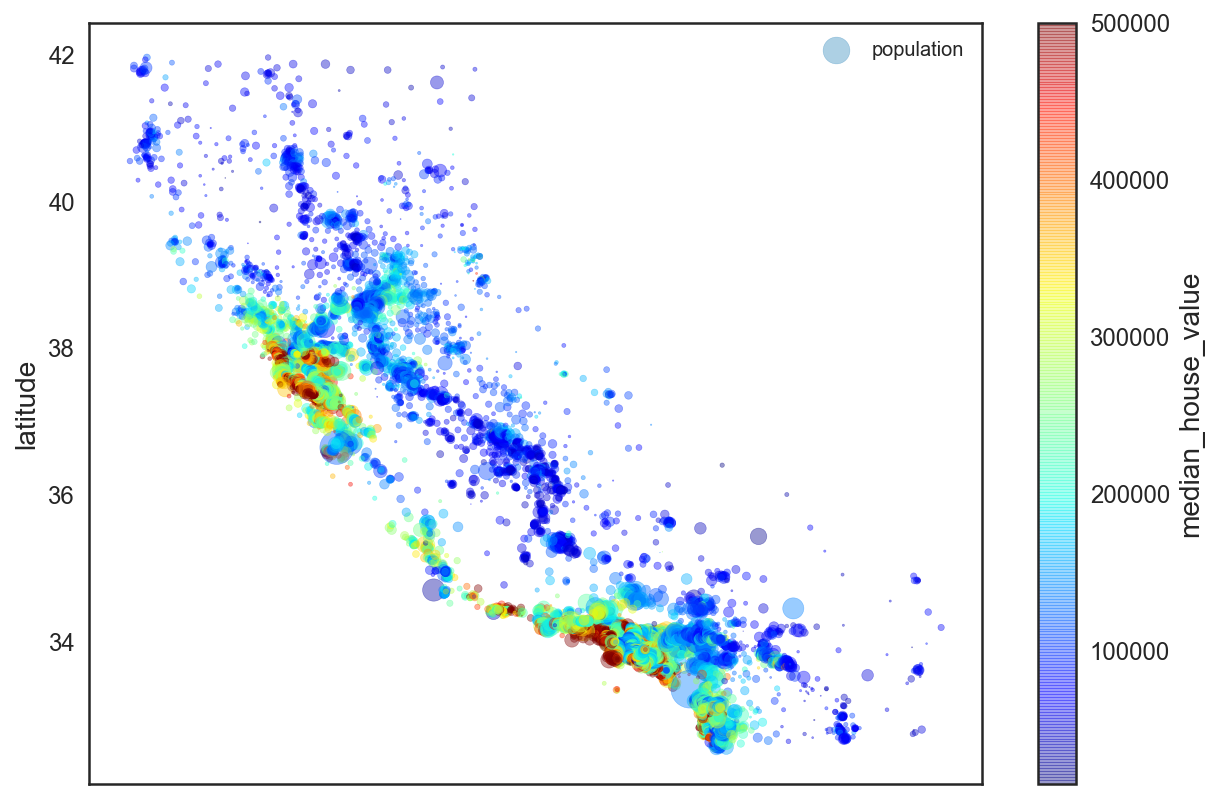

In [11]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True
            );
plt.legend();

In [12]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7fc0c044acf8>)

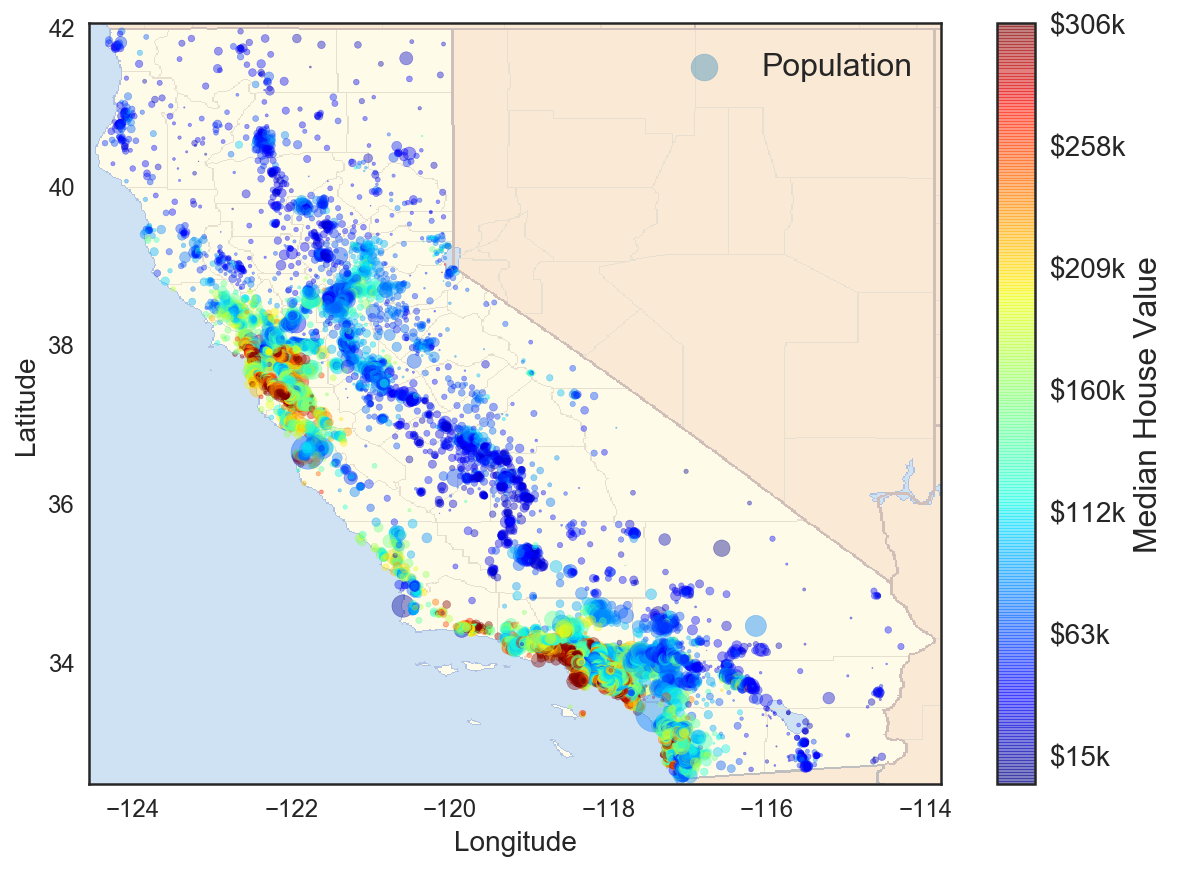

In [13]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show();

This is about what we would expect. The highest median house values are clustered around the most populous metro areas and coastlines. Let's look at correlations between some of our more promising features.

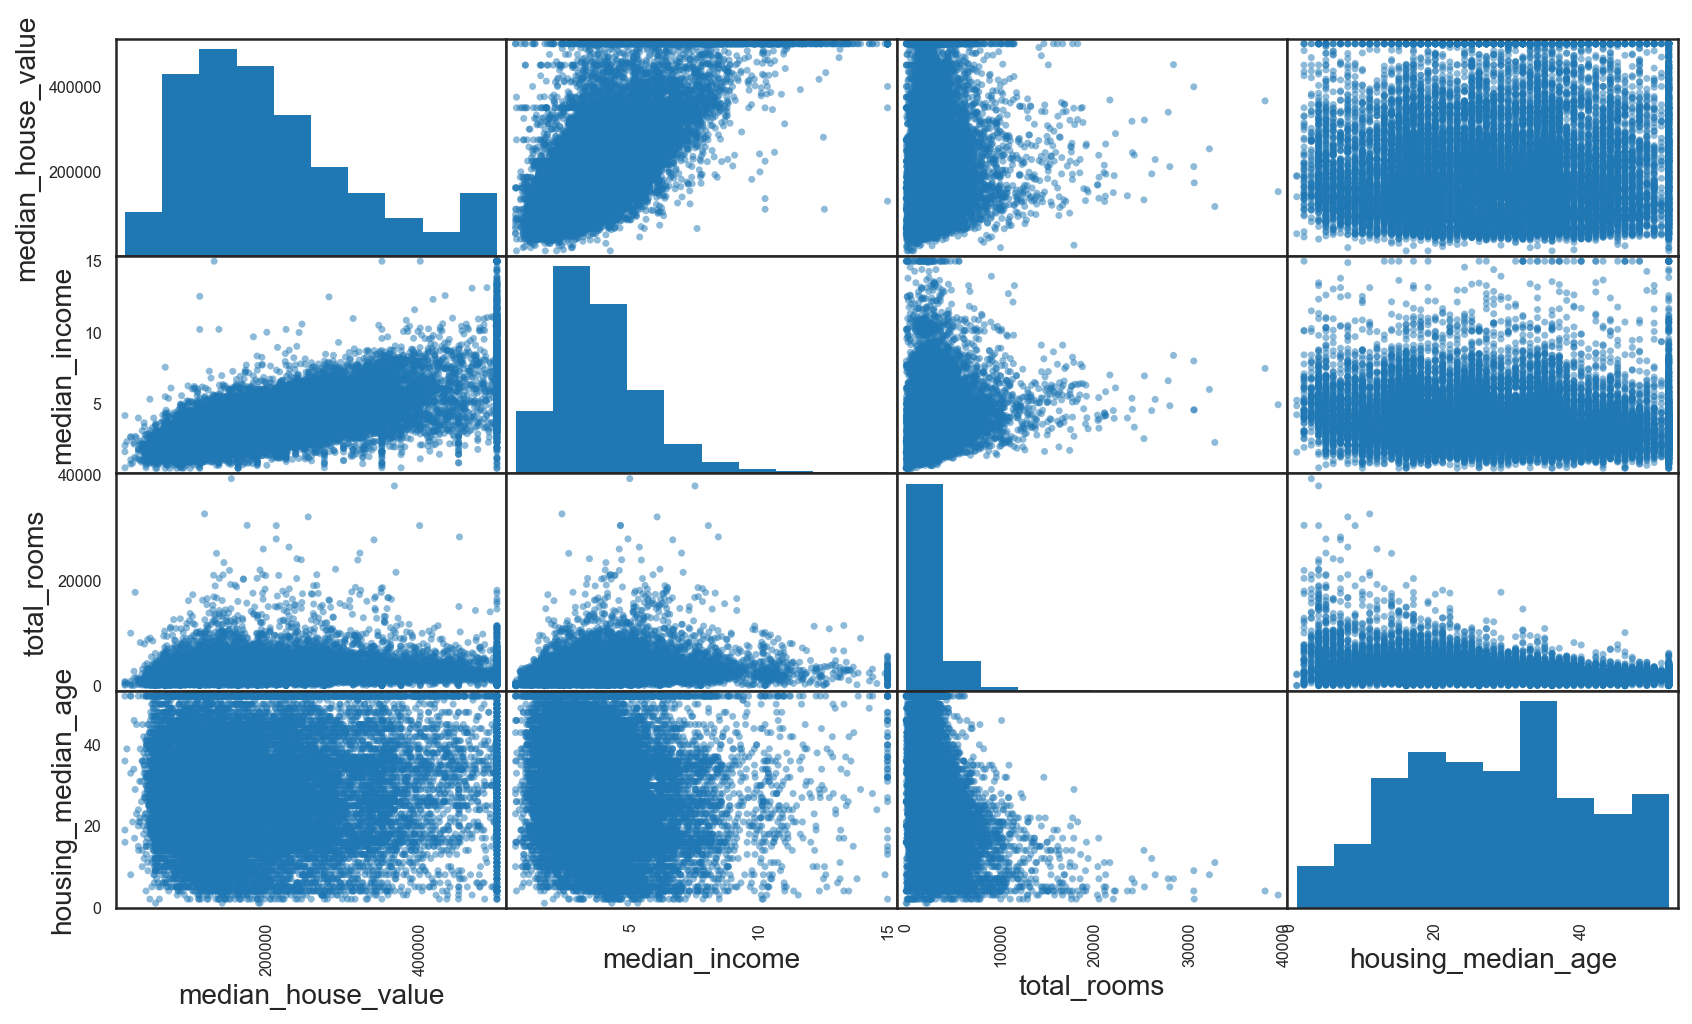

In [14]:
features = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[features], figsize=(14,8));

It appears that there is a positive correlation between our target (house value) and median income. Let's take a closer look.

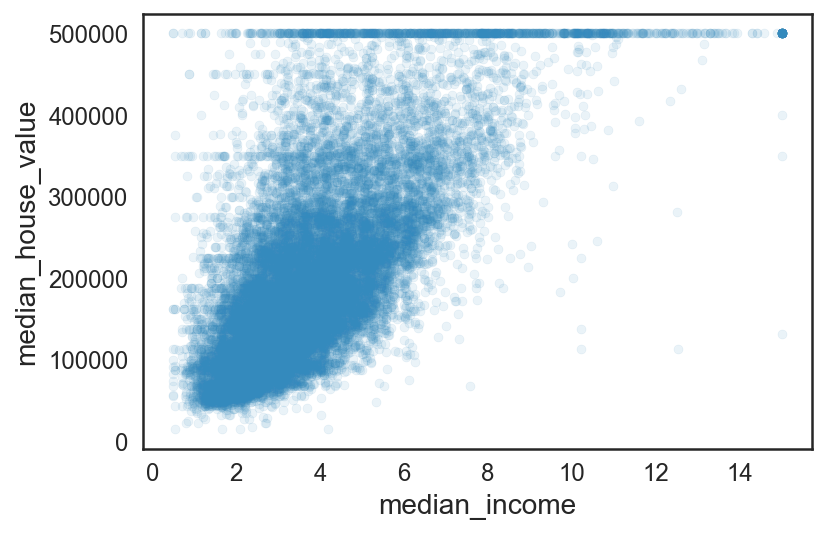

In [15]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1);

There are some quirks with the data. Clearly visible is the house value cap of \\$500,000 that we saw earlier, represented by a horizontal line at the top of the graph, but we also notice other more subtle characteristics, like horizontal lines around \\$450,000, $350,000, and perhaps elsewhere too. For now, let's not get too bogged down in this. We'll do some feature engineering.

## Feature Engineering

Let's create some features from our existing ones that may prove more meaningful and ultimately provide more signal to our ML algorithms. We'll create three features:
1. Rooms per household
2. Bedrooms per room
3. Population per household

In [16]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [17]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

This is a decent improvement. The `bedrooms_per_room` feature is more strongly correlated with `median_house_value` than just the total number of rooms or bedrooms. It seems that lower bedroom/room ratios translate to more expensive houses. Additionally, the number of rooms per household is more informative than just total number of rooms in a district. It makes sense that the larger a house is, the more expensive it should be.

#### Impute NAs and Separate Labels from Training Data

In [53]:
from sklearn.impute import SimpleImputer

# separate labels from training data & drop missing values
housing = copy.deepcopy(train)
housing = housing.drop('median_house_value', axis=1)
y_train = copy.deepcopy(train['median_house_value'])
housing_num = housing.drop("ocean_proximity", axis=1)

imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)
X = imputer.transform(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

#### Custom Transformer for Engineered Features

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

#### Transformation Pipeline

In [55]:
from sklearn.pipeline import Pipeline

# create pipeline for numeric features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [56]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing.drop('ocean_proximity', axis=1))
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

## Modeling

### Linear Regression

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, y_train)
lin_reg_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(y_train, lin_reg_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

68628.19819848922

This is not a good predictor. Either the model is inadequate or the data is. Let's try a more complex model before going back to the features.

### Decision Tree Regressor

In [58]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, y_train)
scores = cross_val_score(tree_reg, housing_prepared, y_train, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)  # Scikit-Learn's CV features expect utlity function (> is better), not cost function (< is better), so 
                                     # we make the scores negative before calculating the square root
    
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())
    
display_scores(tree_rmse_scores)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Scores:  [69222.00450657 68031.70360977 69074.81085319 69024.10768236
 70487.7544832  75746.32351494 71709.38250738 71655.79192625
 77373.24921003 69625.56910336]
Mean: 71195.06973970612
Standard Deviation: 2922.8867213152284


In [59]:
lin_scores = cross_val_score(lin_reg, housing_prepared, y_train, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.6740017983443


Unfortunately, the linear regression model was actually better than the decision tree model. Let's try one more.

### Random Forest Regressor

In [60]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, y_train)
forest_scores = cross_val_score(forest_reg, housing_prepared, y_train, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Scores:  [52207.43897882 51359.38768377 51821.32620137 56016.18443184
 52650.78104303 56302.72292478 52420.29312755 50266.6250619
 55321.73416104 51398.74697421]
Mean: 52976.52405882954
Standard Deviation: 2014.762590774342


This is a significant improvement, but let's keep trying.

### XGBoost Regressor

In [76]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')
xgb_reg.fit(housing_prepared, y_train)
xgb_scores = cross_val_score(xgb_reg, housing_prepared, y_train, scoring='neg_mean_squared_error', cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

Scores:  [52056.36777099 49897.25202193 52875.58279806 55219.63304289
 53215.38148905 56019.44318581 50929.49959547 50775.14967982
 56506.79613124 53597.20486028]
Mean: 53109.231057552926
Standard Deviation: 2153.951090593369


## Tuning

In [107]:
from sklearn.model_selection import RandomizedSearchCV

forest_reg = RandomForestRegressor()
param_grid = {
    'n_estimators': [50, 75, 100, 125, 150, 175, 200], 'max_features': np.linspace(2, 16, 15, dtype=int),
}

random_search = RandomizedSearchCV(forest_reg, param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, random_state=42)
random_search.fit(housing_prepared, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=

In [114]:
cvresults = random_search.cv_results_
for mean_score, params in zip(cvresults['mean_test_score'], cvresults['params']):
    print(np.sqrt(-mean_score), params)

48959.84380931408 {'n_estimators': 100, 'max_features': 6}
49337.90768228537 {'n_estimators': 100, 'max_features': 11}
49511.26666173293 {'n_estimators': 75, 'max_features': 11}
49037.30872651907 {'n_estimators': 150, 'max_features': 9}
48902.88586515269 {'n_estimators': 125, 'max_features': 8}
49932.35244179142 {'n_estimators': 125, 'max_features': 15}
50152.45993691131 {'n_estimators': 200, 'max_features': 16}
48948.37506952872 {'n_estimators': 175, 'max_features': 8}
49982.42910201117 {'n_estimators': 125, 'max_features': 3}
51987.93126612751 {'n_estimators': 50, 'max_features': 2}


In [112]:
random_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=125,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

## Analysis

In [118]:
feature_importances = random_search.best_estimator_.feature_importances_
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.3535587699971169, 'median_income'),
 (0.15926704110841852, 'INLAND'),
 (0.11354453658288337, 'pop_per_hhold'),
 (0.06950790873980557, 'bedrooms_per_room'),
 (0.06905294349480058, 'longitude'),
 (0.06522757272861399, 'latitude'),
 (0.05443063518600934, 'rooms_per_hhold'),
 (0.04324380415631501, 'housing_median_age'),
 (0.015798904324439266, 'total_rooms'),
 (0.014955746103010021, 'population'),
 (0.01480463900515747, 'total_bedrooms'),
 (0.014285051792962003, 'households'),
 (0.006633714896213071, '<1H OCEAN'),
 (0.003207073665728685, 'NEAR OCEAN'),
 (0.0024143421709073892, 'NEAR BAY'),
 (6.731604761888524e-05, 'ISLAND')]

This is interesting, as it shows that there are a lot of relatively unimportant features. Let's remove some of them and see if our model performs better.

In [150]:
fetch_housing_data()
new_housing = load_housing_data()
new_housing['income_cat'] = pd.cut(new_housing['median_income'],
                              bins=[0, 1.5, 3, 4.5, 6, np.inf],
                              labels=[1,2,3,4,5])

# Encode Ocean Proximity column as single binary column: 'near_water' : 0=inland, 1=all others
new_housing['ocean_proximity'] = new_housing['ocean_proximity'].map({'INLAND':0}).fillna(1)
new_housing = new_housing.rename({'ocean_proximity':'near_water'}, axis=1)

In [151]:
# create new pipeline
new_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])        

In [152]:
# Resplit data
train, test = train_test_split(new_housing, test_size=0.2, random_state=42, stratify=new_housing['income_cat'])

# remove income_cat column to restore data to its original form
for set_ in (train, test):
    set_.drop('income_cat', axis=1, inplace=True)

In [153]:
# separate labels and drop target from train df
y_train = copy.deepcopy(train['median_house_value'])
y_test = copy.deepcopy(test['median_house_value'])
train = train.drop('median_house_value', axis=1)
test = test.drop('median_house_value', axis=1)

# drop unuseful columns
drops = ('total_rooms', 'population', 'total_bedrooms', 'households')
drop_idxs = [new_housing.columns.get_loc(c) for c in drops if c in new_housing]

X_tr = new_pipeline.fit_transform(train)
X_tr.shape
X_tr = np.delete(X_tr, drop_idxs, 1)
X_tr.shape

(16512, 12)

(16512, 8)

In [154]:
forest_reg = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': np.linspace(50, 300, 249, dtype=int), 'max_features': np.linspace(2, 8, 7, dtype=int),
    'max_depth': np.linspace(10, 110, 11, dtype=int), 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

random_search = RandomizedSearchCV(forest_reg, param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, n_iter=50, random_state=42)
random_search.fit(X_tr, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [159]:
random_search.best_estimator_
np.sqrt(-random_search.best_score_)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=50,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=293,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

47556.20015618919

In [172]:
cvresults = random_search.cv_results_
scores = [np.sqrt(-x) for x in cvresults['mean_test_score']]
scores = list(zip(scores, cvresults['params']))
sorted(scores)[0]

(47556.20015618919,
 {'n_estimators': 293,
  'min_samples_split': 5,
  'min_samples_leaf': 1,
  'max_features': 2,
  'max_depth': 50,
  'bootstrap': False})

This is a modest improvement. Let's move forward with this model.

### 🥒 Model Pickle 🥒

In [174]:
# with open('random_search.pickle', 'wb') as to_write:
#      pickle.dump(random_search, to_write)

In [175]:
with open('random_search.pickle', 'rb') as to_read:
    random_search = pickle.load(to_read)

### Test Set Evaluation

In [177]:
# transform the test data through the pipeline
test = new_pipeline.transform(test)
test = np.delete(test, drop_idxs, 1)

In [179]:
# Use model to make predictions
final_predictions = random_search.predict(test)

# Evaluate the predictions
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

45749.85650970503